In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(15)
import numpy as np
np.random.seed(15)

In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint

## Developing an agent for SCML2021 (OneShot)

In 2021, we introduced a new track called SCML-OneShot which implements a simplified problem in which the agent can focus on the many to many concurrent negotiation problem without needing to worry about long term planning or production planning as is the case with the standard and collusion tracks. 

**SCML-OneShot brief introduction** Please refer to the first tutorial for a brief introduction about the world simulated in this game as well as pointers to more information. We will assume knowledge of at least this brief introduction in the remainder of this tutorial.

In [3]:
from collections import defaultdict
import random
from negmas import ResponseType
from scml.oneshot import *
from scml.scml2020 import is_system_agent
from pprint import pprint

def try_agent(agent_type, n_processes=2):
    """Runs an agent in a world simulation against a randomly behaving agent"""
    return try_agents([RandomOneShotAgent, agent_type], n_processes)

def try_agents(agent_types, n_processes=2, n_trials=1, draw=True, agent_params=None):
    """
    Runs a simulation with the given agent_types, and n_processes n_trial times.
    Optionally also draws a graph showing what happened
    """
    type_scores = defaultdict(float)
    counts = defaultdict(int)
    agent_scores = dict()
    for _ in range(n_trials):
        p = n_processes if isinstance(n_processes, int) else random.randint(*n_processes)
        world = SCML2020OneShotWorld(
        **SCML2020OneShotWorld.generate(agent_types, agent_params=agent_params, n_steps=10, 
                                        n_processes=p, random_agent_types=True),
        construct_graphs=True,
        )
        world.run()

        all_scores = world.scores()
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            key = aid if n_trials == 1 else f"{aid}@{world.id[:4]}"
            agent_scores[key] = (
                 agent.type_name.split(':')[-1].split('.')[-1],
                 all_scores[aid],
                 '(bankrupt)' if world.is_bankrupt[aid] else ''
                )
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            type_ = agent.type_name.split(':')[-1].split('.')[-1]
            type_scores[type_] += all_scores[aid]
            counts[type_] += 1
    type_scores = {k: v/counts[k] if counts[k] else v for k, v in type_scores.items()}
    if draw:
        world.draw(
            what=["contracts-concluded"],
            steps=(0, world.n_steps),
            together=True, ncols=1, figsize=(20, 20)
        )
        plt.show()

    return world, agent_scores, type_scores

def analyze_contracts(world):
    """
    Analyzes the contracts signed in the given world
    """
    import pandas as pd
    data = pd.DataFrame.from_records(world.saved_contracts)
    return data.groupby(["seller_name", "buyer_name"])[["quantity", "unit_price"]].mean()


def print_agent_scores(agent_scores):
    """
    Prints scores of individiual agent instances
    """
    for aid, (type_, score, bankrupt) in agent_scores.items():
        print(f"Agent {aid} of type {type_} has a final score of {score} {bankrupt}")

def print_type_scores(type_scores):
    """Prints scores of agent types"""
    pprint(sorted(tuple(type_scores.items()), key=lambda x: -x[1]))

Now we are ready to develop a do-nothing agent:

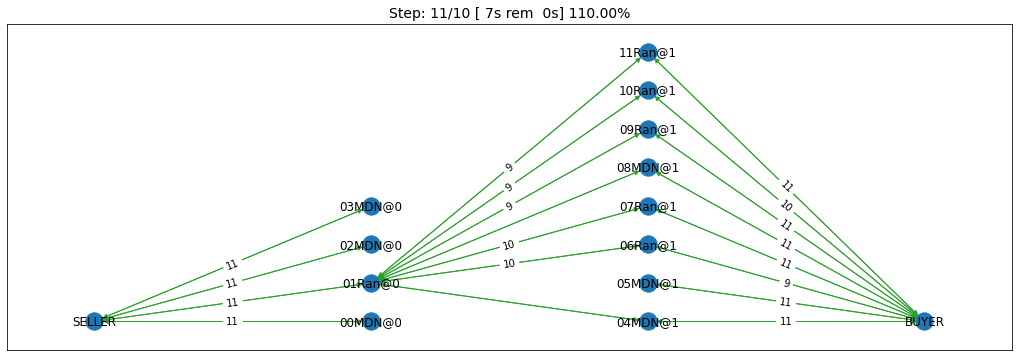

In [4]:
class MyOneShotDoNothing(OneShotAgent):
    """My Agent that does nothing"""
    def propose(self, negotiator_id, state):
        return None
    def respond(self, negotiator_id, state, offer):
        return ResponseType.END_NEGOTIATION
    
world, ascores, tscores = try_agent(MyOneShotDoNothing)

In all of the graph representing world simulations, we use short names that represent the type of the agent. For example an agent named `03Ran@1` is an agent of type `RandomOneShotAgent` at production level 1 that was the third agent to create. `MDN` here is a shorthand for `MyOneShotDoNothingAgent` (we will usually remove `OneShot` and `Agent` from the name before shortening it).

Looking at the `contracts-concluded`, we can see that none of the concluded contracts involved our do-nothing agent. Nevertheless, these agents still had *exogenous contracts* which means that they will lose money. A do-nothing agent will usually lose money in this game.

Let's check the scores of different agents to confirm:

In [5]:
print_agent_scores(ascores)

Agent 00MDN@0 of type MyOneShotDoNothing has a final score of 0.5618181128339336 
Agent 01Ran@0 of type RandomOneShotAgent has a final score of 0.9081418202903606 
Agent 02MDN@0 of type MyOneShotDoNothing has a final score of 0.6849210221645556 
Agent 03MDN@0 of type MyOneShotDoNothing has a final score of 0.6039422056361495 
Agent 04MDN@1 of type MyOneShotDoNothing has a final score of 0.8093176794772545 
Agent 05MDN@1 of type MyOneShotDoNothing has a final score of 0.8958313153141294 
Agent 06Ran@1 of type RandomOneShotAgent has a final score of 0.8312144433846187 
Agent 07Ran@1 of type RandomOneShotAgent has a final score of 0.9999103091383097 
Agent 08MDN@1 of type MyOneShotDoNothing has a final score of 0.534721932591117 
Agent 09Ran@1 of type RandomOneShotAgent has a final score of 0.793391012209533 
Agent 10Ran@1 of type RandomOneShotAgent has a final score of 0.9889886016313895 
Agent 11Ran@1 of type RandomOneShotAgent has a final score of 0.9513575103666706 


Notice that our do-nothing agent always loses money. That is because it cannot get any contracts from negotiation to satisfy its needs from the exogenous contracts but it still has to pay for disposal cost and shortfall penalty.

In [6]:
print_type_scores(tscores)

[('RandomOneShotAgent', 0.9121672828368137),
 ('MyOneShotDoNothing', 0.6817587113361899)]


Notice how the do-nothing agent is even worse than acting randomly. This is usually the case in the OneShot game.

We can also have a look at the *exogenous* contracts that drive the market.

In [7]:
analyze_contracts(world)

quantity  unit_price
seller_name buyer_name                      
01Ran@0     04MDN@1     6.000000    9.000000
            06Ran@1     3.900000   15.300000
            07Ran@1     5.100000   11.400000
            08MDN@1     7.000000   20.000000
            09Ran@1     4.444444   16.000000
            10Ran@1     4.333333   14.555556
            11Ran@1     4.777778   15.222222
04MDN@1     BUYER       5.000000   27.400000
05MDN@1     BUYER       2.500000   26.700000
06Ran@1     BUYER       2.375000   28.250000
07Ran@1     BUYER       5.400000   28.100000
08MDN@1     BUYER       5.000000   29.000000
09Ran@1     BUYER       9.500000   29.300000
10Ran@1     BUYER       2.555556   29.777778
11Ran@1     BUYER       3.800000   26.200000
SELLER      00MDN@0     9.600000   10.900000
            01Ran@0     9.800000   10.200000
            02MDN@0     8.300000    9.700000
            03MDN@0     9.300000   10.500000

There are few things to note about the distribution of the *exogenous* contracts:

- The unit price of the raw material is always lower than that of the final product. This is the source of profitability in this market.
- Each agent has a different mean and standar deviation for the quantities in its exogenous contracts. This means that different agents will have different utility functions but these utility functions for different steps are related because the exogenous contract is sampled from some common distribution for each agent for all the steps which makes learning more useful in the game.

### Building your own agent


A one-shot agent needs only to do negotiation. The simplest possible version (`MyOneShotRandom` above) just responded to offers from its partners and proposed new offers to them. 

Looking at the graph for the world simulation, we can see immediately some features of the one-shot simulation that are not replicated in the full SCML game:

- All negotiation requests are accepted. In fact in the one-shot game, the agent need not consider requesting negotiations or deciding the negotiation agenda as the system takes care of this ensuring that on every simulated day every agent is negotiating with its suppliers and or consumers about trade on that day (and only that day).
- Contracts in the one-shot game are always executed (despite not showing that in the graph). There is no concept of a breach. Failure to honor contracts is instead penalized monetarily. Contracts are also never cancelled or nullified. This greatly simplifies the problem as the agent does not need to keep track of contract execution.
- Production is too fast that it does not affect the agent reasoning. In the terminology to be presented in the following tutorial, there is no need for an explicit production strategy.
- There is no need to consider future negotiations while reasoning about a the current set of negotiations. This greatly simplifies agent design as there is no long-term planning. In the terminology to be presented in the following section, there is no need for a trading strategy


#### Your AWI

As described in the [previous tutorial](http://www.yasserm.com/scml/scml2020docs/tutorials/01.run_scml2020.html), your agent can sense and act in the simulation by accessing methods and properties of its AWI which is accessible at any time as:

```python
self.awi
```

You can see all of these methods and properties specific for the **OneShotAWI** and its descendents [here](http://www.yasserm.com/scml/scml2020docs/api/scml.oneshot.OneShotAWI.html).

#### Your ufun

The Oneshot game has the advantage that it is possible at the end of each simulation step (day) to calculate **exactly** the profit you will be getting for the set of contracts you have (either through negotiation or as exogenous contracts). We provide a utility function class ([OneShotUtilityFunction](http://www.yasserm.com/scml/scml2020docs/api/scml.oneshot.OneShotUFun.html) which can be used normally as any NegMAS [UtilityFunction](http://www.yasserm.com/negmas/api/negmas.preferences.UtilityFunction.html). This ufun is available to your all the time (a new one is created for each simulation step) and is accessible as:

```python
self.ufun
```

The most important services this ufun class provides for you are the following:

- `from_offers`: This method receives a list of outcomes and a list of booleans indicating whether each of them is for buying or for selling. It returns to you the profit you will get if all of these outcomes *and nothing else* became contracts. An outcome is just a tuple  (quantity, delivery time, unit price). You can use this callback during negotiation to judge hypothetical agreements with your partners. 
- `from_contracts`: This method is the same as `from_offers` but it receives a list of `Contract` objects. It is useful after all negotiations are finished to calculate the profit you will be getting for this step.
- `is_breach`: will tell you whether or not getting the given total input and output quantities will make you cause a breach. Notice that breaches are expected in the OneShot track as any mismatch in the quantities of inputs and outputs will constitute a breach.
- `breach_level`: returns a value between zero and one specifying the level of breach that will be recorded for a given total input and output quantities.
- `find_limit`: finds either the maximum or the minimum possible profit (minimum profit is maximm loss) attainable in the current simulation step (day). This is useful when you want to normalize utility values between zero and one. Two of the agents we will develop during this tutorial will use this feature.
- `max_utility`, `min_utility`: give the maximum and minimum utilities/profits attainable. Note that you must prepare them by calling `find_limit`. We will go into how to do that later.
- `best`, `worst`: give more information about the cases of maximum and minimum profit (i.e. the total input and output quantity needed, the prodcible quantity, best possible prices for buying and selling, etc). Again, these are not available except after calling `find_limit`.


#### Your callbacks

Your agent needs to implement methods that are called by the system at various time during the negotiation. You can find a full list in the [game description]().

The most important ones are:

- `init()` called once at the beginning of the simulation (i.e. before the first day starts). At this point, your AWI is set but you should not assume anything else.
- `before_step()` called at the **beginning** of *every day*. At this point, your `ufun` is set and market information is available.
- `step()` called at the **end** of *every day*. You can use this to analyze what happened during the day and modify your strategy in the future.
- `on_negotiation_success()`/`on_negotiation_failure()` called after each negotiation is concluded to let you know what happened in it.
- Depending on your base-class, you will also need to implement methods that allow you to control negotiations. These will be explained in details in the following sections but here is a summary:
   - **OneShotAgent** If your agent is based on `OneShotAgent`, you will get a `propose()` call when you need to offer something to one of our partners during negotiation and `respond()` when asked to respond to one of its offers.
   - **OneShotSyncAgent** If your agent is based on `OneShotSyncAgent` you will get a call to `first_proposals()` once every day to set your first proposal in all negotiations and a `counter_all()` call to counter offers from your partners. The system will try to always give you one offer from each partner in the `counter_all()` call but that is not guaranteed and sometimes it may be called with a subset of the offers.
   - **OneShotSingleAgreementAgent** If your agent is based on `OneShotSingleAgreementAgent` you will have to implement `is_acceptable()` to decide if a given offer is acceptable to you, `best_offer()` to find the *best* offer in a given negotiation for your agent and `is_better()` to compare two offers. Once you implement these, the agent will implement all callback for you trying to get **a single** agreement that maximizes your utility. Note that, again, it is not guaranteed that you will get a single agreement at the end but the system will try its best to achieve that.

Now we can start working on our agent.

There are three base classes for one-shot agents (`OneShotAgent`, `SyncOneShotAgent`, and `SingleAgreementOneShotAgent`). We will discuss them in more details in what follows.

### OneShotAgent

This is the base class of all agents for SCML-OneShot. Both `SyncOneShotAgent` and `SingleAgreementOneShotAgent` inherit from this class and provide support for a simplified way of developing your agent (or so we think). It is perfectly OK to use `OneShotAgent` directly as the base of your agent.

We have already seen the `OneShotAgent` class for which you need to override `propose` and may also override `respond` to handle negotiations independently. The `propose` method receives the negotiation state (an object of the type `SAOState` including among other things the current negotiation step, relative time, last offer, etc) and is required to return an `Outcome` (See `negmas` documentation) as an offer. The `respond` method receives a negotiation state and an offer (`Outcome`) from the opponent and needs to respond to it by a decision from the `ResponseType` enumeration (`REJECT_OFFER`, `ACCEPT_OFFER`, and `END_NEGOTIATION`). Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `propose` are optional.

#### Simple OneShotAgent 
We have already seen how to develop a do-nothing agent using the `OneShotAgent` class. Let's try to develop some more meaningful agent using the same base class.


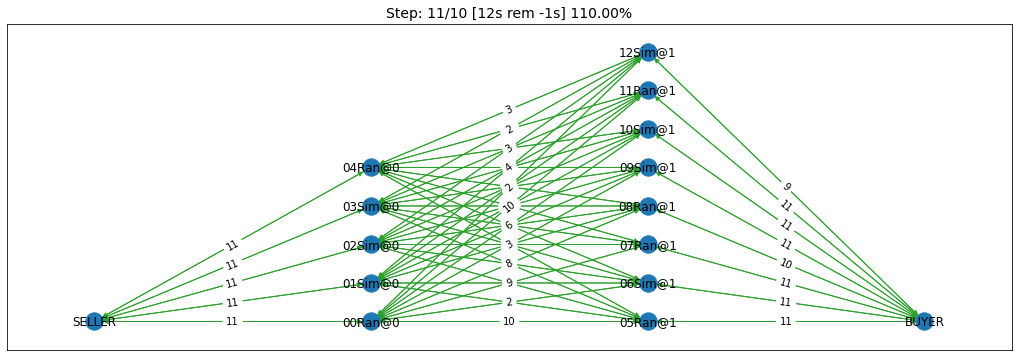

In [8]:
class SimpleAgent(OneShotAgent):
    """A greedy agent based on OneShotAgent"""

    def before_step(self):
        self.secured = 0

    def on_negotiation_success(self, contract, mechanism):
        self.secured += contract.agreement["quantity"]

    def propose(self, negotiator_id: str, state) -> "Outcome":
        return self.best_offer(negotiator_id)

    def respond(self, negotiator_id, state, offer):
        my_needs = self._needed(negotiator_id)
        if my_needs <= 0:
            return ResponseType.END_NEGOTIATION
        return (
            ResponseType.ACCEPT_OFFER
            if offer[QUANTITY] <= my_needs
            else ResponseType.REJECT_OFFER
        )

    def best_offer(self, negotiator_id):
        my_needs = self._needed(negotiator_id)
        if my_needs <= 0:
            return None
        ami = self.get_nmi(negotiator_id)
        if not ami:
            return None
        quantity_issue = ami.issues[QUANTITY]
        unit_price_issue = ami.issues[UNIT_PRICE]
        offer = [-1] * 3
        offer[QUANTITY] = max(
            min(my_needs, quantity_issue.max_value),
            quantity_issue.min_value
        )
        offer[TIME] = self.awi.current_step
        if self._is_selling(ami):
            offer[UNIT_PRICE] = unit_price_issue.max_value
        else:
            offer[UNIT_PRICE] = unit_price_issue.min_value
        return tuple(offer)

    def _needed(self, negotiator_id=None):
        return self.awi.current_exogenous_input_quantity + \
               self.awi.current_exogenous_output_quantity - \
               self.secured

    def _is_selling(self, ami):
        return ami.annotation["product"] == self.awi.my_output_product
    
world, ascores, tscores = try_agent(SimpleAgent)

Let's see how well did this agent behave:

In [9]:
print_type_scores(tscores)

[('SimpleAgent', 1.1356185762391608),
 ('RandomOneShotAgent', 0.5750174958460608)]


This simple agent is slightly better than the random agent. Let's understand how it works:

The main idea of this agent is pretty simple. It tries to *secure* as much of its needs (sales/supplies) as possible in every negotiation at the best possible price for itself.

To achieve this goal, the agent keeps track of the quantity it secured in its `init`, `step` and `on_negotiation_success` callbacks.

```python
def before_step(self):
    self.secured = 0

def on_negotiation_success(self, contract, mechanism):
    self.secured += contract.agreement["quantity"]

```

Moreover, it defines a helper that calculates the amount it needs by subtracting the exogenous quantity it has from the amount it secured:

```python
def _needed(self):
    return self.awi.current_exogenous_input_quantity + \
           self.awi.current_exogenous_output_quantity - \
           self.secured
```

Notice that either the exogenous input quantity or the exogenous output quantity (or both) will always be zero. Now that the agent can calculate how much it needs to buy/sell, it implements the negotiation related call-backs (`propose` and `respond`). 

Here is the full implementation of `propose`:
```python
def propose(self, negotiator_id: str, state) -> "Outcome":
        return self.best_offer(negotiator_id)
```

The agent is always offering its best offer which is calculated in the `best_offer` method to be discussed later. It does not conceed at all.

Responding to opponent offers is also simple:

- it starts by calculating its needs using the helper `needed`, and ends the negotiation if it needs no more sales/supplies
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return ResponseType.END_NEGOTIATION
```
- If the offered quantity is less than its needs, accept the offer. Otherwise reject the offer.
```python
    return ResponseType.ACCEPT_OFFER if offer[QUANTITY] <= my_needs else ResponseType.REJECT_OFFER
```

Most of the code is in the `best_offer` method which calculates the best offer for a negotiation *given the agreements reached so far*. Let's check it line by line:

- The agent checks its needs and returns `None` ending the negotiation if it needs no more sales/supplies. We also get access to the AMI.
```python
    my_needs = self._needed()
    if my_needs <= 0:
        return None
    ami = self.get_nmi(negotiator_id)
    if not ami:
        return None
```

- It then finds out the `Issue` objects corresponding to the quantity and unit-price for this negotiation and initializes an offer (we have 3 issues)
```python
    quantity_issue = ami.issues[QUANTITY]
    unit_price_issue = ami.issues[UNIT_PRICE]
    offer = [-1] * 3
```
- The time is always the current step. 
```python    
    offer[TIME] = self.awi.current_step
```
- The quantity to offer is simply the needs of the agent without mapped within the range of the quantities in the negotiation agenda (note that this may lead the agent to buy more than its needs). 
```python    
    offer[QUANTITY] = max(
        min(my_needs, quantity_issue.max_value), quantity_issue.min_value
    )
```
- Finally, the unit price is the maximum possible unit price if the agent is selling otherwise it is the minimum possible price. Note that `is_selling()` assumes that the agent will never find itself in a middle layer in a deep negotiation. We will alleviate this issue later. 
```python
    if self._is_selling(ami):
        offer[UNIT_PRICE] = unit_price_issue.max_value
    else:
        offer[UNIT_PRICE] = unit_price_issue.min_value
    return tuple(offer)
```

### A better greedy agent

One problem with our `SimpleAgent` is that it does not take price into account in two ways:

- When asked to `propose`, it *always* proposes an offer with the best price for itself. It **never concedes** on prices. In many cases this will lead to disagreement.
- When asked to `respond` to an offer, *it does not even check the price*. This may lead to bad agreements (i.e. very high buying prices/very low selling prices).

We will try to remedie both of these issues in the following agent:

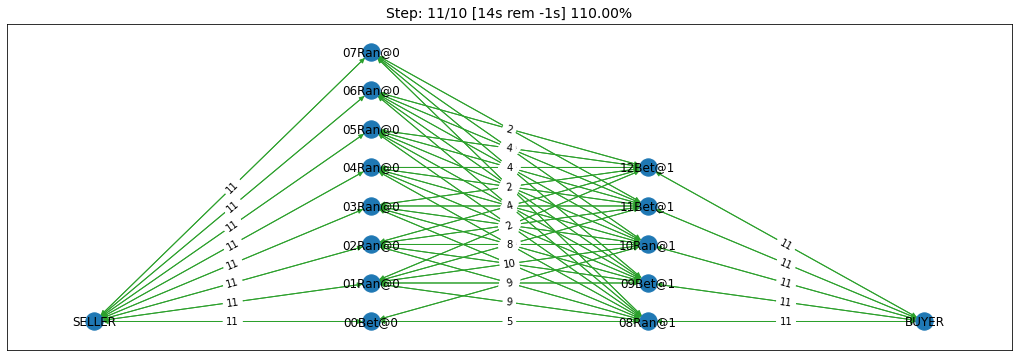

In [10]:
class BetterAgent(SimpleAgent):
    """A greedy agent based on OneShotAgent with more sane strategy"""
    
    def __init__(self, *args, concession_exponent=0.2, **kwargs):
        super().__init__(*args, **kwargs)
        self._e = concession_exponent

    def propose(self, negotiator_id: str, state) -> "Outcome":
        offer = super().propose(negotiator_id, state)
        if not offer:
            return None
        offer = list(offer)
        offer[UNIT_PRICE] = self._find_good_price(
            self.get_nmi(negotiator_id), state
        )        
        return tuple(offer)

    def respond(self, negotiator_id, state, offer):
        response = super().respond(negotiator_id, state, offer)
        if response != ResponseType.ACCEPT_OFFER:
            return response
        ami = self.get_nmi(negotiator_id)
        return (
            response if
            self._is_good_price(ami, state, offer[UNIT_PRICE])
            else ResponseType.REJECT_OFFER
        )
        
    def _is_good_price(self, ami, state, price):
        """Checks if a given price is good enough at this stage"""
        mn, mx = self._price_range(ami)
        th = self._th(state.step, ami.n_steps)        
        # a good price is one better than the threshold
        if self._is_selling(ami):
            return (price - mn) >= th * (mx - mn)
        else:
            return (mx - price) >= th * (mx - mn)
    
    def _find_good_price(self, ami, state):
        """Finds a good-enough price conceding linearly over time"""        
        mn, mx = self._price_range(ami)
        th = self._th(state.step, ami.n_steps)
        # offer a price that is around th of your best possible price
        if self._is_selling(ami):
            return mn + th * (mx - mn)
        else:
            return mx - th * (mx - mn)
    
    def _price_range(self, ami):
        """Finds the minimum and maximum prices"""
        mn = ami.issues[UNIT_PRICE].min_value
        mx = ami.issues[UNIT_PRICE].max_value           
        return mn, mx
    
    def _th(self, step, n_steps):
        """calculates a descending threshold (0 <= th <= 1)"""
        return ((n_steps - step - 1) / (n_steps - 1)) ** self._e    
        
world, ascores, tscores = try_agent(BetterAgent)

Let's see how well did this agent behave:

In [11]:
print_type_scores(tscores)

[('BetterAgent', 1.1862566718070788),
 ('RandomOneShotAgent', 0.7433509112677118)]


It seems that `BetterAgent` is getting higher scores than `SimpleAgent` as expected. Let's dive into the agent and analyze how it works:

The main idea in `BetterAgent` is to treat the *price* issue separately to avoid the two issues presented earlier:

- **Never conceding during proposal** This is solved in the `propose` method by just overriding the price with a `good-enough` price:
  ```python
    offer[UNIT_PRICE] = self._find_good_price(
            self.get_nmi(negotiator_id), state
        )        
  ```
  As an aside, notice that we needed to convert the offer to a list in order to overwrite the price then back into a tuple to send it to the partner.
- **Never checking prices of offers** This is solved in the `respond` method by checking whether or not the price offered is a `good-enough` price:
  ```python
    return (
            response if
            self._is_good_price(ami, state, offer[UNIT_PRICE])
            else ResponseType.REJECT_OFFER
        )
  ```

What we mean by a `good-enough` price is defined in `_is_good_price` and `_find_good_price` methods. Both start by getting the limits of the unit-price in the negotiation agenda and a threshold value ```th```:

```python
mn, mx = self._price_range(ami, state)
th = self._th(mn, mx, state.step, ami.n_steps)
```

The price range is clear enough. For the threshold ```th``` is a value that starts at $1.0$ and goes down toward $0.0$ over the negotiation time under the control of an agent specific parameter ```_e``` called the concession exponent.
Let's see how does this look for different concession exponents:

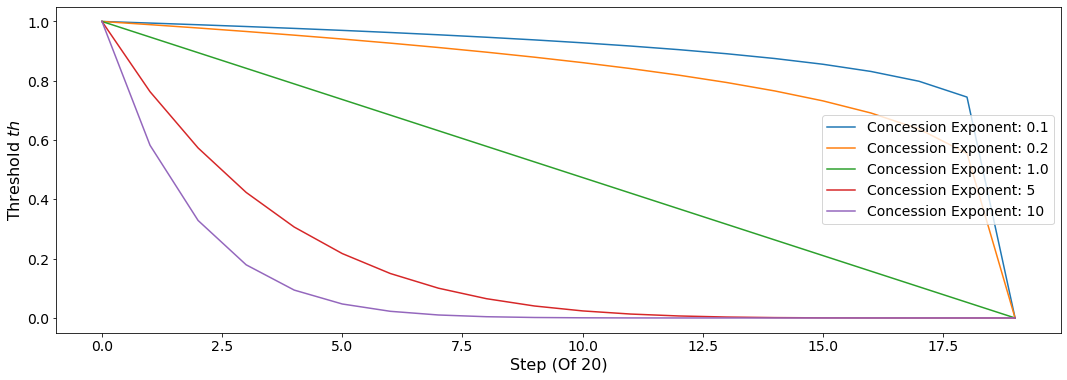

In [12]:
x = np.arange(20)
fig = plt.figure()
for e in [0.1, 0.2, 1.0, 5, 10]:
    a = BetterAgent(concession_exponent=e)
    y = [a._th(i, 20) for i in x]
    plt.plot(x, y, label=f"Concession Exponent: {e}")
    plt.xlabel("Step (Of 20)"); plt.ylabel("Threshold $th$")
    plt.legend()

You can see that the smaller the exponent the more *hard-headed* will the agent be. Setting the concession exponent to $0$ will recover the behavior of the `SimpleAgent` in offering but will make it insisting on an unrealistic best price when responding to partner offers (can you see why?) which is definitely a bad idea. Setting it to $\inf$ will recover the behavior of `SimpleAgent` in responding to offers but will make its offers least favorable for itself in terms of price (can you see why?)

Given this threshold function, we can now define `is_good_price` and `_find_good_price`:

- ```_is_good_price``` simply compares the price given to it to the current threshold defined by multiplying ```th``` by the price range```mx - mn```
   - When selling this is achieved by comparing the difference between the price and minimum price to the curren threshold:
    ```python
    return (price - mn) >= th * (mx - mn)
    ```
    You can check that this will give the maximum unit price in the first step and gradually goes down to the minimum unit price in the last step (```n_steps - 1```)
   - When buying we go the other way around (starting at minimum price and going up over time to the maximum price):
   ```python
   return (mx - price) >= th * (mx - mn)
   ```
   
- ```_find_good_price``` works in the same fashion but rather than checking the goodness of a price, it simply uses the threshold to generate a ```good-enough``` price:
   ```python
    if self._is_selling(ami):
        return mn + th * (mx - mn)
    else:
        return mx - th * (mx - mn)
    ```


### Thinking about other negotiations

So far, our agent behaved **indepdendently** in each negotiation without considering what is happening in the others (except when one of them completes changing the amount `secured`). A simple way to consider other negotiations is to use the prices offered in them to limit our concessions. The following agent implements this idea
    

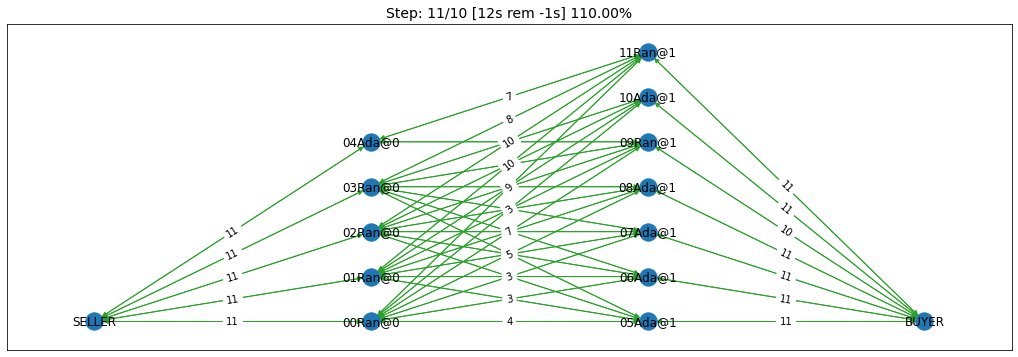

In [13]:
class AdaptiveAgent(BetterAgent):
    """Considers best price offers received when making its decisions"""

    def before_step(self):
        super().before_step()
        self._best_selling, self._best_buying = 0.0, float("inf")
                     
    def respond(self, negotiator_id, state, offer):
        """Save the best price received"""
        response = super().respond(negotiator_id, state, offer)
        ami = self.get_nmi(negotiator_id)
        if self._is_selling(ami):
            self._best_selling = max(offer[UNIT_PRICE], self._best_selling)
        else:
            self._best_buying = min(offer[UNIT_PRICE], self._best_buying)
        return response
    
    def _price_range(self, ami):
        """Limits the price by the best price received"""
        mn, mx = super()._price_range(ami)
        if self._is_selling(ami):
            mn = max(mn, self._best_selling)
        else:
            mx = min(mx, self._best_buying)
        return mn, mx

world, ascores, tscores = try_agent(AdaptiveAgent)

Let's see how well did this agent behave:

In [14]:
print_type_scores(tscores)

[('AdaptiveAgent', 1.2968865617946501),
 ('RandomOneShotAgent', 0.5473019874302442)]


Not as good as the previous agent at least in this simulation (we will make a more rigorous comparison later). One possiblity here is that the agent became too hard-headed again because now whenever it sees a good price on one negotiation, it insists on it for all the rest. This may not be a good idea sometimes as it may lead to more disagreements. In general *the agent must balance getting good prices with matching its input and output quantities*.

### Learning over time

Up until now, our simple agents did not change their behavior over simulation time. Whatever they do in one day depends only on information about what is happening on that day. This may not be optimal. For one, the agent may be able to learn about different partners over the simulation time. The following agent tries to do that in a *simplistic* manner by changing the limits of the price it is willing to accept based on accomulated statistics per agent


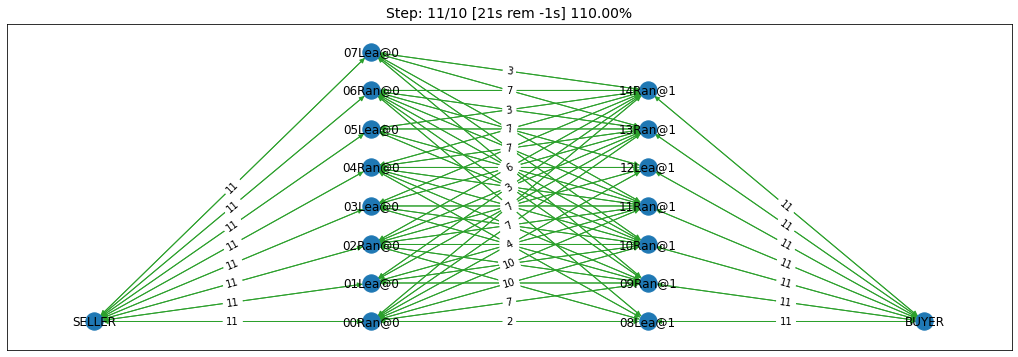

In [15]:
class LearningAgent(AdaptiveAgent):
    def __init__(
        self,
        *args,
        acc_price_slack=float("inf"),
        step_price_slack=0.0,
        opp_price_slack=0.0,
        opp_acc_price_slack=0.2,
        range_slack = 0.03,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self._acc_price_slack = acc_price_slack
        self._step_price_slack = step_price_slack
        self._opp_price_slack = opp_price_slack
        self._opp_acc_price_slack = opp_acc_price_slack
        self._range_slack = range_slack

    def init(self):
        """Initialize the quantities and best prices received so far"""
        super().init()
        self._best_acc_selling, self._best_acc_buying = 0.0, float("inf")
        self._best_opp_selling = defaultdict(float)
        self._best_opp_buying = defaultdict(lambda: float("inf"))
        self._best_opp_acc_selling = defaultdict(float)
        self._best_opp_acc_buying = defaultdict(lambda: float("inf"))        

    def step(self):
        """Initialize the quantities and best prices received for next step"""
        super().step()
        self._best_opp_selling = defaultdict(float)
        self._best_opp_buying = defaultdict(lambda: float("inf"))

    def on_negotiation_success(self, contract, mechanism):
        """Record sales/supplies secured"""
        super().on_negotiation_success(contract, mechanism)

        # update my current best price to use for limiting concession in other
        # negotiations
        up = contract.agreement["unit_price"]
        if self._is_selling(mechanism):
            partner = contract.annotation["buyer"]
            self._best_acc_selling = max(up, self._best_acc_selling)
            self._best_opp_acc_selling[partner] = max(up, self._best_opp_acc_selling[partner])
        else:
            partner = contract.annotation["seller"]
            self._best_acc_buying = min(up, self._best_acc_buying)
            self._best_opp_acc_buying[partner] = min(up, self._best_opp_acc_buying[partner])

    def respond(self, negotiator_id, state, offer):
        # find the quantity I still need and end negotiation if I need nothing more
        response = super().respond(negotiator_id, state, offer)
        # update my current best price to use for limiting concession in other
        # negotiations
        ami = self.get_nmi(negotiator_id)
        up = offer[UNIT_PRICE]
        if self._is_selling(ami):
            partner = ami.annotation["buyer"]
            self._best_opp_selling[partner] = max(up, self._best_selling)
        else:
            partner = ami.annotation["seller"]
            self._best_opp_buying[partner] = min(up, self._best_buying)
        return response
    
    def _price_range(self, ami):
        """Limits the price by the best price received"""
        mn = ami.issues[UNIT_PRICE].min_value
        mx = ami.issues[UNIT_PRICE].max_value
        if self._is_selling(ami):
            partner = ami.annotation["buyer"]
            mn = min(mx * (1 - self._range_slack), max(
                [mn]
                + [
                    p * (1 - slack)
                    for p, slack in (
                        (self._best_selling, self._step_price_slack),
                        (self._best_acc_selling, self._acc_price_slack),
                        (self._best_opp_selling[partner], self._opp_price_slack),
                        (
                            self._best_opp_acc_selling[partner],
                            self._opp_acc_price_slack,
                        ),
                    )
                ]
            ))
        else:
            partner = ami.annotation["seller"]
            mx = max(mn * (1 + self._range_slack),  min(
                [mx]
                + [
                    p * (1 + slack)
                    for p, slack in (
                        (self._best_buying, self._step_price_slack),
                        (self._best_acc_buying, self._acc_price_slack),
                        (self._best_opp_buying[partner], self._opp_price_slack),
                        (
                            self._best_opp_acc_buying[partner],
                            self._opp_acc_price_slack,
                        ),
                    )
                ]
            ))
        return mn, mx

world, ascores, tscores = try_agent(LearningAgent)

In [16]:
print_type_scores(tscores)

[('LearningAgent', 1.6257960387564594),
 ('RandomOneShotAgent', 0.21230948129466296)]


The main idea of this agent is to limit the minimum price (for selling) and/or maximum price (for buying) based on events not only in this day but up until now. To do that, the agent accomulates best prices received in the same way `AdaptiveAgent` did in `init()` and `step()`. 

There are four simple differences between this agent and the previous one:

1. It allows a controlled `slack` in price constraining. For example, if an agent of this type received a selling price of $10$, it will limit the minimum price considered *good-enough* in other negotiations to $10 \times (1 - s)$ where $s$ is the slack term (e.g. setting $s=0.1$, leads to accepting offers at a price of $9$ as good enough). This may give the agent more flexibility and most importantly, this parameter **can be learned offline using any appropriate ML method**
2. A best price **per partner** is kept in a `defaultdict()` that is initialized in `init` and updated in the same way the *partner independent* best prices are updated
3. An `accumulated` statistic is kept (one for wll agents and one per agent) that is only initialized in `init()` and keeps being adjusted in `on_negotiation_success` without being reset in `step()`
4. It keeps a `range_slack` to avoid setting too high minimum (or too low maximum) price. In effect, if the `range_slack` is $x$ then prices within the best $100x\%$ of the best price are *always considered good enough*

The main logic is in `_price_range()`. As usual, it starts by getting the price range from the `AMI`:

```python
mn = ami.issues[UNIT_PRICE].min_value
mx = ami.issues[UNIT_PRICE].max_value
```

If the agent is a seller, it finds the partner ID:
```python
partner = ami.annotation["buyer"]
```

Now that the partner is known, we can read the best offers received so far (in this day and over all days) for this partner. We can also retrieve the corresponding two partner-independent best prices with the corresponding slacks:

```python
(
    (self._best_selling, self._step_price_slack),
    (self._best_acc_selling, self._acc_price_slack),
    (self._best_opp_selling[partner], self._opp_price_slack),
    (
        self._best_opp_acc_selling[partner],
        self._opp_acc_price_slack,
    ),
)
```

For each price $p$ and slack value $slack$, we find the corrsponding price limit as:
```python
p * (1 - slack)
```

We then set the *good-enough* price limit to be the **maximum** of these four prices and the minimum price of the current negotiation (adjusted by the `range_slack` value). 
Finally we make sure that this is not too high by taking the **minimum** of this value and the maximum price of the current negotiation.


### More General Simple Agent (advanced)

<div style="color: red;">This section is not necessary for SCML-OneShot 2021 competition because all worlds in the competition will have exactly 2 processes (3 products). It is here for readers interested in making their agents future-proof.</div>

One issue that the `SimpleAgent` had was that it assumed that it is either in the first level of the production chain or in the last level. To make an agent that works anywhere, we need just minor modifications:

In [17]:
class DeepSimpleAgent(SimpleAgent):
    """A greedy agent based on OneShotSyncAgent that does something 
    when in the middle of the production chain"""
    
    def before_step(self):
        self._sales = self._supplies = 0
        
    def on_negotiation_success(self, contract, mechanism):
        if contract.annotation["product"] == self.awi.my_input_product:
            self._sales += contract.agreement["quantity"]
        else:
            self._supplies += contract.agreement["quantity"]
        
    def _needed(self, negotiator_id):
        summary = self.awi.exogenous_contract_summary
        secured = ( 
            self._sales 
            if self._is_selling(self.get_nmi(negotiator_id)) 
            else self._supplies
        )
        demand = min(summary[0][0], summary[-1][0]) / (self.awi.n_competitors + 1)     
        return  demand - secured

Firstly, we now keep track of our sales and supplies separately:

```python
def before_step(self):
    self._sales = self._supplies = 0

def on_negotiation_success(self, contract, mechanism):
    if contract.annotation["seller"] == self.id:
        self._sales += contract.agreement["quantity"]
    else:
        self._supplies += contract.agreement["quantity"]
```

To find out whether a contract is for sales or supplies, we simply check that the `seller` in the contract annotation is us. 

We need now one more chanage which is to separate the calculation of our needs for supplies and sales:
```python
def _needed(self, negotiator_id):
    summary = self.awi.exogenous_contract_summary
    secured = ( 
        self._sales 
        if self._is_selling(self.get_nmi(negotiator_id)) 
        else self._supplies
    )
    demand = min(summary[0][0], summary[-1][0]) / (self.awi.n_competitors + 1)     
    return  demand - secured
```

here we start by reading the summary information of exogenous contracts into `summary`. This is a list of two valued tuples giving the **total** quantity and **total** price (in that order) of all current exogenous contracts for all products. We also find the amount we secured (depending on whether this is a buy or a sell negotiation) and the number of competitors (i.e. agents in the same production level as us). We assume that we need to buy (and sell) the same quantity as the minimum of the raw material and final product exogenous contracts divided equally between us and our competitors (we add one to `n_competitors` to count ourselves).

Now, let's see how does this agent behave compared with the previous agent in a deep world simulation


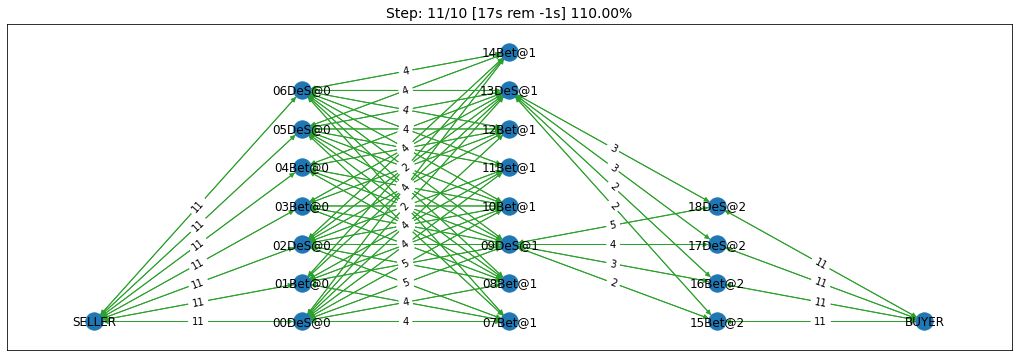

In [18]:
world, ascores, tscores = try_agents([BetterAgent, DeepSimpleAgent], n_processes=3)

Examining the graph above, you can see that `DeepSimple` agents could get contracts when they were in the middle of the production chain. The `Simple` agent on the other hand cannot do so. 

Agents in the package `scml.oneshot.agents` were designed to work in deep production graphs not only in the first and last layer whenever that is possible.

We can check the results now:

In [19]:
print_type_scores(tscores)

[('DeepSimpleAgent', 0.6524917531285761), ('BetterAgent', 0.4547078968677247)]


Even though our new `DeepSimpleAgent` was able to get contracts which in the middle, it seems that it did worse than `SimpleAgent` in terms of final profits. This may be just a quirk of this specific configuration. We will leave it to the reader to investigate this issue (if they choose to).

Given that the utility function of the agent is defined in terms of a *complete set of contracts*, it is not trivial to define a utility function for each negotiation independent from the others (which is why this is an inherently concurrent negotiation world). It may be easier then to think of all negotiations in a synchronized manner. This means that the agent keeps collecting offers from its partners and when it has a *complete set*, it responds to all of them. Moreover, to start negotiations in which the agent finds itself the first propsoer, it needs to define a first proposal for each negotiation. This is why `SyncOneShotAgent` allows you to do. 

<span style="color:blue">
You can now start developing your own agent for SCML-OneShot (A startup skeleton project is available <a href=http://www.yasserm.com/scml/oneshot.zip>here</a>). The rest of this tutorial will introduce two other <strong>optional</strong> alternatives</span>


### OneShotSyncAgent

One problem that plagued all of our agents so far is that they have to make decisions (`respond`, `propose`) about negotiations **on the spot**. This makes it difficult to consider **all other negotiations** while making decisions. 

Because the utility function is defined for **a complete set of negotiation agreements** and not for any single negotiation by itself, it makes sense to try to make decisions **centrally** by collecting offers from partners then responding to all of them at once. It is possible to do that by utilizing the response type ```ResponseType.WAIT``` supported by NegMAS but this entails a lot of house-keeping. 

To simplify this task, we provide another base class for agents that does all of this house keeping for you exposing a simple interface that **syncrhonizes** all negotiations (as much as allowed by the underlying platform). The main goal of this base agent is to allow the developer to think about *all negotiations together* but it has some important caveats which we will discuss later.
Here is an example of writing the do-nothing agent in this form:

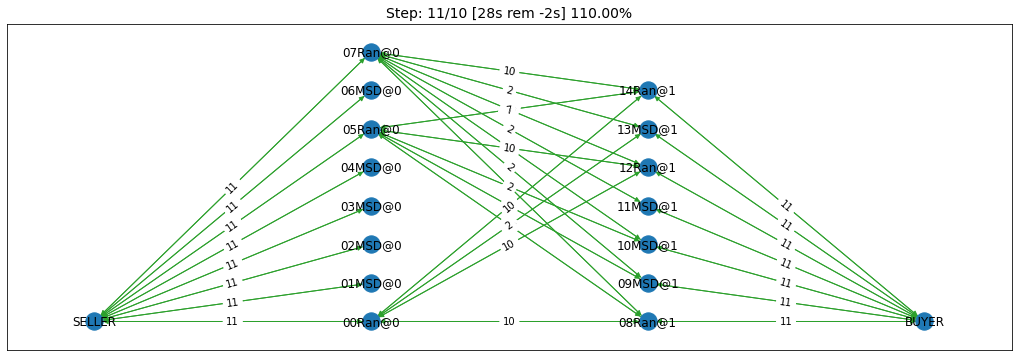

In [20]:
from negmas import SAOResponse
class MySyncOneShotDoNothing(OneShotSyncAgent):
    """My Agent that does nothing"""
    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""
        return dict(zip(self.negotiators.keys(), 
                        [SAOResponse(ResponseType.END_NEGOTIATION, None)] 
                        * len(self.negotiators)
                       ))
    
    def first_proposals(self):
        """Decide a first proposal on every negotiation. 
        Returning None for a negotiation means ending it."""
        return dict(zip(self.negotiators.keys(), 
                        [None] * len(self.negotiators)
                       ))
    
world, ascores, tscores = try_agent(MySyncOneShotDoNothing)

As you can see, in this case, we need to override `counter_all` to counter offers received from *all* the partners and `first_proposals` to decide a first offer for *each* partner. Notice that this is a many-to-many negotiation scenario. This means that if multiple agents at every level are using sync variants, loops may happen with the possiblity of a deadlock. 

For that reason the system will randomly break such loops when they happen which implies that **`counter_all` may receive a subset of the offers from partners not all of them**. In the worst case, `counter_all` may receive just one offer each time from one of the partners losing all synchronity between responses.

Other than these two negotiation related callbacks, the agent receives an `init` call just after it joins the simulatin and a `step` call after each step. The agent is also informed about failure/success of negotiations through the `on_negotiation_success`/`on_negotiation_failure` callbacks. That is all. A one-shot agent needs to only think about what should it do to respond to each of these six callbacks. All of these callbacks except `counter_all` and `first_proposals` are optional.

#### SyncAgent

The main advantage of using the `OneShotSyncAgent` is that you do not need to keep track of state variables (like `secured`, `_supplies` and `_sales` used earlier) and you have a common place to make your decisions about **all** negotiations at the same time. Here is a simple greedy agent using this approach.

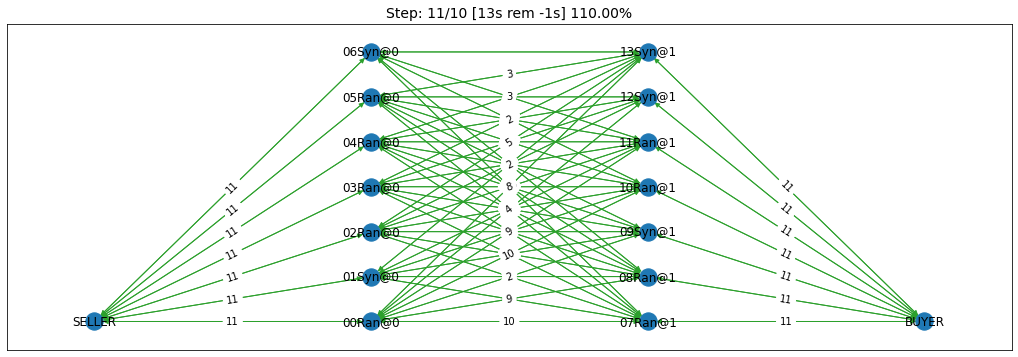

In [21]:
class SyncAgent(OneShotSyncAgent, BetterAgent):
    """A greedy agent based on OneShotSyncAgent"""
    
    def __init__(self, *args, threshold=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self._threshold = threshold
    
    def before_step(self):
        super().before_step()
        self.ufun.find_limit(True)
        self.ufun.find_limit(False)
        
    def first_proposals(self):
        """Decide a first proposal on every negotiation. 
        Returning None for a negotiation means ending it."""
        return  dict(zip(
                self.negotiators.keys(), 
                (self.best_offer(_) for _ in self.negotiators.keys())
        ))
    
    def counter_all(self, offers, states):
        """Respond to a set of offers given the negotiation state of each."""
        responses = {
            k: SAOResponse(ResponseType.REJECT_OFFER, v) 
            for k, v in self.first_proposals().items()
        }
        my_needs = self._needed()
        is_selling = ( self._is_selling(self.get_nmi(_)) for _ in offers.keys() )
        sorted_offers = sorted(
            zip(offers.values(), is_selling), 
            key=lambda x: (- x[0][UNIT_PRICE]) if x[1] else x[0][UNIT_PRICE]
        )
        secured, outputs, chosen = 0, [], dict()
        for i, k in enumerate(offers.keys()):
            offer, is_output = sorted_offers[i]
            secured += offer[QUANTITY]
            if secured >= my_needs:
                break
            chosen[k] = offer
            outputs.append(is_output)
            
        u = self.ufun.from_offers(list(chosen.values()), outputs)
        rng = self.ufun.max_utility - self.ufun.min_utility
        threshold = self._threshold * rng + self.ufun.min_utility
        if u >= threshold:
            for k, v in chosen.items():
                responses[k] = SAOResponse(ResponseType.ACCEPT_OFFER, None)                
        return responses
    
world, ascores, tscores = try_agent(SyncAgent)

This agent shows a case of parameterizing your agent so that it can be tested with different hyper-parameters. You do that by passing whatever parameters you like as keyword arguments to the constctor:

```python
def __init__(self, *args, threshold=0.3, **kwargs):
    super().__init__(*args, **kwargs)
    self._threshold = threshold
```

The one paramter we have is a threshold of utility relative to the maximum possile utility that we are willing to accept.

This agent also shows a case in which we use the built-in utility function implemented by the system (see [Section 2.3 of the game description](http://www.yasserm.com/scml/scml2021oneshot.pdf)). This ufun is accessible as `ufun`. By default the ufun will return the profit in dollars for a given set of negotiation outcomes, offers, agreements, or contracts. Note that the ufun assumes that what it is given *is the complete set of agreements and no others will be added to them later*. This value may be positive or negative (loss). In some cases you need to get the utility value normalized to a range between zero and one. This agent will do that. To do this normalization, we need to know the value of maximum and minimum utilities. You can of course solve the corresponding optimziation problem but we did that for you. All you need is call `find_limit` and pass it a boolean (`True` for calculating the highest possible utility and `False` for calculating the lowest possible utility). To avoid doing this calculation repeatedly, you should store the results in `ufun.best` or `ufun.worst` for highest and lowest utility. After that, you can access the maximum possible utility as `max_utility` and minimum possible utility as `min_utility`. We do that in the `before_step()` method (called at the beginning of every day):

```python
 def before_step(self):
    super().init()
    self.ufun.find_limit(True)
    self.ufun.find_limit(False)
```

After this call, we can access `maximum_utility`, `minimum_utility`, `best`, `worst` members of the ufun. As explained earlier, `best` and `worst` give extra information about the conditions for achieving maximum and minimum utility.

We need to implement two methods: `first_proposals` (to generate a good first proposal for each negotiation) and `counter_all` (for countering a set of offers). We inherit from `SimpleAgent` in order to get access to `best_offer` and `_is_selling` methods (we could have repeated them here again of course. Note that, because of the way inheritence works in python, we must inherit from `OneShotSyncAgent` before `SimpleAgent`.

The first set of proposals in `first_proposals` is simply the `best_offer` for each negotiation which is calculated using this generator expression:
```python
(self.best_offer(_) for _ in self.negotiators.keys())
```


Almost all the code now resides in the `counter_all` method. We will go over it here:

- We start by initializing our response by the best offer for each negotiation using `first_proposals` and calculating our needs using `_needed`
```python
responses = {
    k: SAOResponse(ResponseType.REJECT_OFFER, _) 
    for k, v in self.first_proposals().items()
}
my_needs = self._needed(None)
```

- We then sort the offers so that earlier offers have *better* prices for us. For sell offers, this means descendingly and for buy offers ascendingly.
```python
is_selling = ( self._is_selling(self.get_nmi(_)) for _ in offers.keys() )
sorted_offers = sorted(
    zip(offers.values(), is_selling), 
    key=lambda x: (- x[0][UNIT_PRICE]) if x[1] else x[0][UNIT_PRICE]
)
```
- We *greedily* find a set of offers that satisfy all our needs (or as much as possible from them). 
```python
secured, outputs, chosen = 0, [], dict()
for i, k in enumerate(offers.keys()):
    offer, is_output = sorted_offers[i]
    secured += offer[QUANTITY]
    if secured >= my_needs:
        break
    chosen[k] = offer
    outputs.append(is_output)
```
- Finally, we calculate the utility of accepting these *and only these* offers and accept the chosen offers if they provide 70% of the maximum possible utility. Otherwise, we reject all offers sending the default `best_offer` value back.
```python
u = self.ufun.from_offers(list(chosen.values()), outputs)
rng = self.ufun.max_utility - self.ufun.min_utility
threshold = self._threshold * rng + self.ufun.min_utility
if u >= threshold:
    for k, v in chosen.items():
        responses[k] = SAOResponse(ResponseType.ACCEPT_OFFER, None)
return responses
```

Let's see how did it do:

In [22]:
print_type_scores(tscores)

[('SyncAgent', 1.176891964031303), ('RandomOneShotAgent', 0.5444786046801005)]


This base-class simplifies the job of the agent developer by providing a single function (`counter_all`) in which to handle all offers it receive (most of the time, remember that sometimes you will receive a subset of the offers in the call). In principle the agent can then decide to accept a few of these offers and keep negotiating. 

In many cases, it may be possible to secure all of the agent's needs (i.e. supplies or sales) using a **single** contract with one of its partners. In such cases, the agent can think about the negotiations it is engaged in as a **competetive negotiation** not very dissimilar from an auction that also allows it to offer. This can lead to a further simplification, the agent can be designed to get **at most one agreement** from the set of negotiation and end all the rest once this is achieved. This is what the `SingleAgreementOneShotAgent` does.

### SingleAgreementOneShotAgent
This base classs allows you to develop agents that can get **at most** one agreement from the set of negotiation at every simulation step. 

This controller manages a set of negotiations from which only a single one
-- at most -- is likely to result in an agreement. To guarentee a single agreement, pass ```strict=True```.

The general algorithm for this controller is something like this:

- Receive offers from all partners.
- Find the best offer among them by calling the abstract `best_offer`
  method.
- Check if this best offer is acceptable using the abstract `is_acceptable`
  method.

    - If the best offer is acceptable, accept it and end all other negotiations.
    - If the best offer is still not acceptable, then all offers are rejected
      and with the partner who sent it receiving the result of `best_outcome`
      while the rest of the partners receive the result of `make_outcome`.

- The default behavior of `best_outcome` is to return the outcome with
  maximum utility.
- The default behavior of `make_outcome` is to return the best offer
  received in this round if it is valid for the respective negotiation
  and the result of `best_outcome` otherwise.
  
To use this agent, you need to implement three methods:

- `is_acceptable` decides whether an offer is now acceptable. For this simple agent, we accept an offer if it provides us with a decreasing fraction of the maximum utility attainable. Notice that, because we set `mn` to `min_utility`, the agent may actually accept offers with negative utility!! This can easily be fixed by setting `mn` to zero but will lead to much less trade.
```python
mx, mn = self.ufun.max_utility , self.ufun.min_utility
u = (self.ufun(offer) - mn) / (mx - mn) 
return  u >= (1-state.relative_time)
```
- `best_offer` finds the best offer among a set of offers. Here we simply compare their utility
```python
ufuns = [(self.ufun(_), i) for i, _ in enumerate(offers.values())]
keys = list(offers.keys())
return keys[max(ufuns)[1]]
```
- `is_better` which compares two offers from the same negotiator. We simply compare their utility value:
```python
return self.ufun(a) > self.ufun(b)
```

Here is the full agent

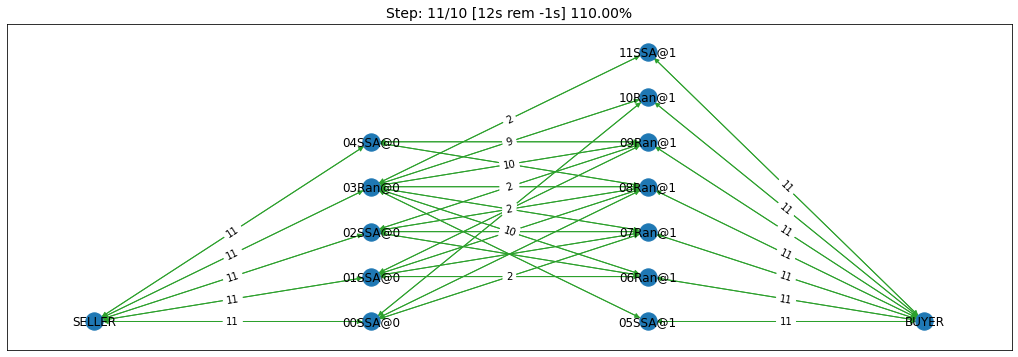

In [23]:
class SimpleSingleAgreementAgent(OneShotSingleAgreementAgent):
    """A greedy agent based on OneShotSingleAgreementAgent"""
    
    def before_step(self):
        self.ufun.find_limit(True) # finds highest utility
        self.ufun.find_limit(False) # finds lowest utility
    
    def is_acceptable(self, offer, source, state) -> bool:        
        mx, mn = self.ufun.max_utility , self.ufun.min_utility
        u = (self.ufun(offer) - mn) / (mx - mn) 
        return  u >= (1-state.relative_time)

    def best_offer(self, offers):
        ufuns = [(self.ufun(_), i) 
                 for i, _ in enumerate(offers.values())]
        keys = list(offers.keys())
        return keys[max(ufuns)[1]]

    def is_better(self, a, b, negotiator, state):
        return self.ufun(a) > self.ufun(b)

world, ascors, tscores = try_agent(SimpleSingleAgreementAgent)

In [24]:
print_type_scores(tscores)

[('SimpleSingleAgreementAgent', 0.9932815012206001),
 ('RandomOneShotAgent', 0.5763022972303052)]


### Using Independent Negotiators

The SCML game is at its core a concurrent negotiation problem. That is why the default `OneShotAgent` receives all calls from the simulator and responds to them centerally. Nevertheless, you man want to structure your agent in a different way. Let's assume that you found a way to create *independent utility functions* to be used with each of your partners. Assuming that your ufuns can summarize what is expected to happen in all other negotiations, you can use the `OneShotIndNegotiatorsAgent` to build an agent that delegates all of its control to independent negotiators that use these per-partner utility functions. 

In this case, you only need to implement `generate_ufuns()` which is responsible of creating these **independent per-partner utility functions** every day. You need also to specify the negotiator to be used with each partner. By default the agent will create an `AspirationNegotiator` for each of your partners. You can override this default behavior by passing custom `default_negotiator_type`/`default_negotiator_params` to the agent constructor. If you need even more control, you can override `generate_negotiator()` to create a custom negotiator object per partner every day. 

This is an example agent that uses this approach:

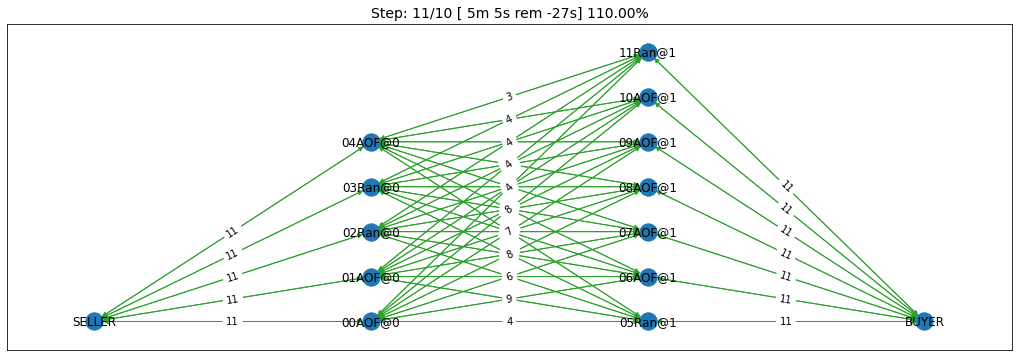

[('AssumeOthersFailIndNeg', 0.13936148735127274),
 ('RandomOneShotAgent', 0.016172548063384265)]


In [25]:
from scml.oneshot import OneShotIndNegotiatorsAgent

class AssumeOthersFailIndNeg(OneShotIndNegotiatorsAgent):
    def generate_ufuns(self):
        return defaultdict(lambda: self.ufun)
world, ascors, tscores = try_agent(AssumeOthersFailIndNeg)
print_type_scores(tscores)

This agent simply uses its **central** ufun for each negotiator. This is not a very good strategy because each negotiator is now assuming that *all other negotiations will fail*. Can you see why?

Let's make a slightly more meaningful agent. This time, the utility function used per partner will try to find a favorable price but will not care about quantity. This is obviously not a good strategy either because the agent may over-contract. 

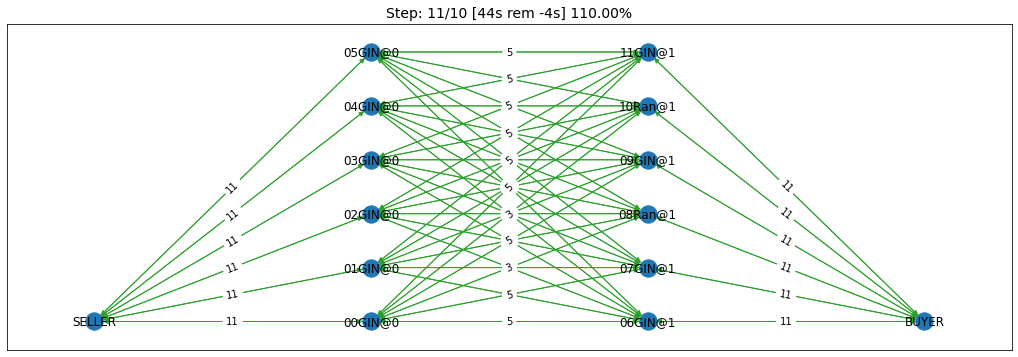

[('GreedyIndNeg', 0.004681314312553092),
 ('RandomOneShotAgent', -0.5575657220089572)]


In [26]:
from negmas.preferences import LinearAdditiveUtilityFunction, LinearUtilityFunction
from negmas.preferences.value_fun import AffineFun, IdentityFun

class GreedyIndNeg(OneShotIndNegotiatorsAgent):
    def generate_ufuns(self):
        d = dict()
        # generate ufuns that prefer higher prices when selling
        for partner_id in self.awi.my_consumers:
            issues = self.awi.current_output_issues
            if self.awi.is_system(partner_id):
                continue
            d[partner_id] = LinearUtilityFunction(
                weights=dict(
                    quantity=0.1,
                    time=0.0,
                    unit_price=0.9,
                ),
                issues=issues,
                reserved_value=0.0,
            )
        # generate ufuns that prefer lower prices when selling
        for partner_id in self.awi.my_suppliers:
            issues = self.awi.current_input_issues
            if self.awi.is_system(partner_id):
                continue
            d[partner_id] = LinearAdditiveUtilityFunction(
                dict(
                    quantity=IdentityFun(),
                    time=IdentityFun(),
                    unit_price=AffineFun(slope=-1, bias=issues[UNIT_PRICE].max_value),
                ),
                weights=dict(
                    quantity=0.1,
                    time=0.0,
                    unit_price=0.9,
                ),
                issues=issues,
                reserved_value=0.0,
            )
        return d

world, ascors, tscores = try_agent(GreedyIndNeg)

print_type_scores(tscores)

#### Using A Negotiator from the Genius Platform

One advantage of this type of agents is that it allows you to use almost any [Genius](http://ii.tudelft.nl/genius/) including most winners of past ANAC competitions as your negotiator once you could come up with a good utility function per partner (not an easy task at all).

To be able to use these genius negotiators, you need to have some extra constraints on your utility function:

- All ufuns are of the type `LinearAdditiveUtilityFunction` or `LinearUtilityFunction`.
- All ufuns are normalized with a maximum value of 1.0. You can
  use `normalize_ufuns=True` to gruarantee that.
- All ufuns have a finite reserved value and at least one outcome is
  above it. You can guarantee that by using `set_reservation=True`.
- All weights of the utility function must be between
  zero and one and the weights must sum to one.


If all of these conditions are satisfied, you can use a Genius based negotiator by following these steps:

1. Install the negmas-genius bridge by running on the terminal (this will download the bridge):
   ```bash
   negmas genius-setup
   ```
4. Run a world or a tournament as usual.

You need to have `java` installed (15.0 or later). *Please note that we do not officially support any Genius agents for SCML. Moreover, due to the way the bridge is implemented, these agents will tend to be much slower than negotiators developed directly in python and may suffer from more timeouts as a result. It may be a good idea to reimplement whatever strategy you prefer in python to guarantee stable performance*.

If your Genius negotiation did not start, you can explicitly run the negmas-genius bridge using one of the following two commands:

- Start the negmas-genius bridbe by running on the terminal:
   ```bash
   negmas genius
   ```
- In some cases, the aforementioned command may not work correctly (specially on windows), you can replace it with:
   ```bash
   java -jar ~/nemga/files/geniusbridge.jar
   ```

The only change you need to do in your code is to choose an appropriate `GeniusNegotiator`. Note that not all agents in the genius platform will work correctly. Here is an example

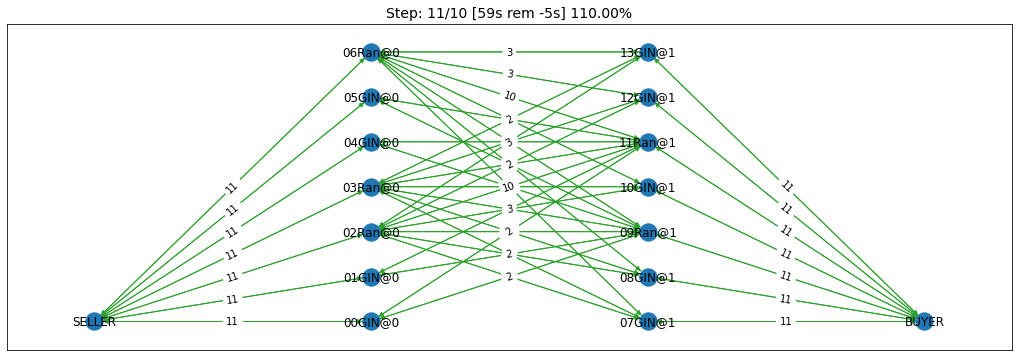

[('GeniusIndNeg', 0.6894105217980112),
 ('RandomOneShotAgent', 0.3327688991455212)]


In [27]:
# import a specific agent from the Genius platform
from negmas.genius import NiceTitForTat
# used to check whether or not the negmas-genius bridge
# is running
from negmas.genius import genius_bridge_is_running

class GeniusIndNeg(GreedyIndNeg):
    def __init__(self, *args, **kwargs):
        kwargs["default_negotiator_type"] = NiceTitForTat
        kwargs["normalize_ufuns"] = True
        super().__init__(*args, **kwargs)

world, ascors, tscores = try_agent(GeniusIndNeg)
print_type_scores(tscores)

### Comparing all agents

Let's run a tournament comparing all agents we developed in this tutorial (we will ignore the do-nothing agents)

In [28]:
# may take a long time
_, _, tscores = try_agents(
    [
        SimpleAgent, DeepSimpleAgent,
        BetterAgent, LearningAgent,
        AdaptiveAgent, SyncAgent, 
        SimpleSingleAgreementAgent, 
        GreedyIndNeg, GeniusIndNeg
    ],
    n_trials=20,
    n_processes=2,
    draw=False
)
print_type_scores(tscores)

[('LearningAgent', 1.4463958847131329),
 ('AdaptiveAgent', 1.3154137165229993),
 ('BetterAgent', 1.2973836475541614),
 ('SyncAgent', 0.9745708025960512),
 ('SimpleAgent', 0.9078002325048111),
 ('SimpleSingleAgreementAgent', 0.717050233070166),
 ('GreedyIndNeg', 0.6425512822841334),
 ('GeniusIndNeg', 0.045902840420665114),
 ('DeepSimpleAgent', 0.0008724822654963152)]


The way we just compared these agents is not unbiased because not all agents are allowed to control the same factories in the same simulation envoironment. The best way to compare these agents is to run a tournament between them. You already learned how to do that in the previous tutorial and we will not repeate it here.

*If you are running this notebook, please note that the tournament running methods `anac2021_*` may not work within a notebook environment. You can just move your code to a normal python script and it will run correctly*


You can find all the agents available in the `scml` package for the one-shot game under `scml.oneshot.agents` including the ones developed in this tutorial (with some modifications):

In [29]:
import scml.oneshot.agents as agents
pprint([ _ for _ in agents.__dir__() if _.endswith("Agent")])

['RandomOneShotAgent',
 'SyncRandomOneShotAgent',
 'SingleAgreementRandomAgent',
 'SingleAgreementAspirationAgent',
 'GreedyOneShotAgent',
 'GreedySyncAgent',
 'GreedySingleAgreementAgent',
 'OneshotDoNothingAgent']


### Running SCML2020 agents (advanced)
<div style="color: red;">This section is not necessary for SCML-OneShot 2021 competition.</div>

The SCML-OneShot game is much simpler than the full SCML2020 game used in the ANAC 2020 SCML league or the ANAC 2021 SCML standard and collusion tracks. Nevertheless, we provide an out-of-the-box adapter allowing agents developed for the full competition to run in the on-shot track (with some rough edges). Let's try to do that here:

In [30]:
from scml.scml2020.agents import BuyCheapSellExpensiveAgent, DecentralizingAgent
from scml.oneshot.agents import SingleAgreementAspirationAgent as AspirationAgent
_, _, tscores = try_agents(
[SimpleAgent, DeepSimpleAgent, BetterAgent, LearningAgent, 
AdaptiveAgent, SyncAgent, AspirationAgent, 
BuyCheapSellExpensiveAgent, DecentralizingAgent],
n_processes = 4,
n_trials = 10,
draw = False,
)

In [31]:
print_type_scores(tscores)

[('BetterAgent', 0.8467803006546885),
 ('SimpleAgent', 0.8114544108909326),
 ('SingleAgreementAspirationAgent', 0.7733837208932579),
 ('DeepSimpleAgent', 0.71514983086698),
 ('AdaptiveAgent', 0.7040722657976939),
 ('LearningAgent', 0.7015257756505888),
 ('DecentralizingAgent', 0.5726874392606705),
 ('SyncAgent', 0.5311544727835437),
 ('BuyCheapSellExpensiveAgent', 0.16316024566432097)]


For an SCML agent participating in the OneShot game, the main issues to take into account are the following:

1. The system will **override** the agenda the agent proposes in negotiation requests with the same agenda it always uses for the one-shot game. More specifically, the time will be the current step for buying negotiation requests and the next step for selling negotiation requests. Quantities and unit prices will also be adjusted as explaind in the [OneShot game description](http://www.yasserm.com/scml/scml2021oneshot.pdf).
2. The agent will not be able to do any trade about any steps beyond the next step. 

With that we end our tutorial. Have fun developing your agent.